# TopoPyScale Benchmarking Against Local Observation
S. Filhol

In [1]:
import requests, os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import rasterio
from scipy import stats


## 1. Downscaled to Weather Station Location

In [2]:
stn = pd.read_csv('inputs/dem/station_list.csv')
stn

,Name,stn_number,latitude,longitude,x,y
0,Finsevatne,SN25830,60.5938,7.5270,419320.867306,6.718448e+06
1,Fet-I-Eidfjord,SN49800,60.4085,7.2798,405243.856318,6.698143e+06
2,Skurdevikåi,SN29900,60.3778,7.5693,421114.679132,6.694343e+06
3,Midtstova,SN53530,60.6563,7.2755,405730.301715,6.725742e+06
4,FV50-Vestredalen,SN53990,60.7418,7.5748,422296.164019,6.734872e+06
5,Klevavatnet,SN53480,60.7192,7.2085,402259.379227,6.732844e+06


In [3]:
run pipeline_point.py


 ------------------------------- 

Point Downscaling Example

 ------------------------------- 

---> Output directory cleaned
---> no FSM directory to clean
---> no ensemble directory to clean

---> DEM file found
{'latN': 60.68443065002782, 'latS': 60.50790355399738, 'lonW': 7.354447266990793, 'lonE': 7.731798660953054}
Project lat/lon extent:

	------------------------------
	|        North:60.7          |
	|West:7.4          East:7.7|
	|        South:60.5          |
	------------------------------


---> Loading ERA5 surf climate forcing
Start =  2018-Oct
End =  2018-Dec
ECWMF SURF data found:
0    SURF_201810.nc
1    SURF_201811.nc
2    SURF_201812.nc
Name: target_file, dtype: object


---> Loading ERA5 plev climate forcing
Start =  2018-Oct
End =  2018-Dec
ECWMF PLEV data found:
0    PLEV_201810.nc
1    PLEV_201811.nc
2    PLEV_201812.nc
Name: target_file, dtype: object

---> Extracting DEM parameters (slope, aspect, svf)
Computing slope and aspect ...
Computing svf ...
---> Fil

## 2. Load Downscaled and Observation Data

In [4]:
# List of weather stations
df_stn = pd.read_csv('./inputs/dem/station_list.csv')

# Downscaled timeseries at weather station location
ds_down = xr.open_mfdataset('./outputs/downscaled/down_pt*.nc', concat_dim='point_id', combine='nested', parallel=True)

In [5]:
df_obs = pd.concat(map(pd.read_pickle, glob.glob("./inputs/obs/metno*.pckl")))

In [6]:
df_stn

,Name,stn_number,latitude,longitude,x,y
0,Finsevatne,SN25830,60.5938,7.5270,419320.867306,6.718448e+06
1,Fet-I-Eidfjord,SN49800,60.4085,7.2798,405243.856318,6.698143e+06
2,Skurdevikåi,SN29900,60.3778,7.5693,421114.679132,6.694343e+06
3,Midtstova,SN53530,60.6563,7.2755,405730.301715,6.725742e+06
4,FV50-Vestredalen,SN53990,60.7418,7.5748,422296.164019,6.734872e+06
5,Klevavatnet,SN53480,60.7192,7.2085,402259.379227,6.732844e+06


In [35]:
print('Observation variables available:')
df_obs.elementId.unique()

Observation variables available:


array(['air_temperature', 'sum(precipitation_amount PT12H)', 'wind_speed',
       'wind_from_direction', 'relative_humidity',
       'air_pressure_at_sea_level'], dtype=object)

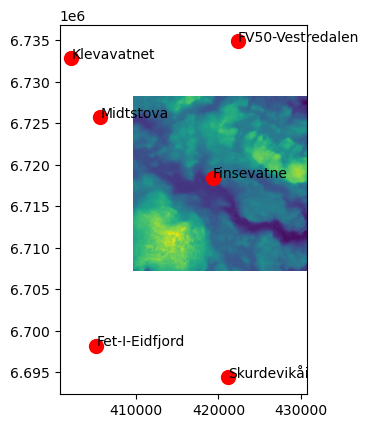

In [32]:
from rasterio.plot import show
dem = rasterio.open('./inputs/dem/ASTER_Finse.tif')

r_extent = [dem.get_transform()[0],
           dem.get_transform()[0] + dem.shape[1]*dem.get_transform()[1],
            dem.get_transform()[3] + dem.shape[1]* dem.get_transform()[-1],
            dem.get_transform()[3]]

plt.figure()
plt.imshow(dem.read(1), extent=r_extent)
plt.scatter(df_stn.x, df_stn.y, s=100, c='r')
for i,row in df_stn.iterrows():
    plt.text(row.x,row.y,row.Name)

In [7]:
# Convert pandas dataframe to xarray dataset
df = pd.pivot_table(df_obs, columns=['elementId'],values=['value'], index=['sourceId', 'referenceTime'])
ds = df.xs('value', axis=1, level=0).to_xarray()      
ds['referenceTime']=pd.to_datetime(ds.referenceTime)

## 3. Compare Downscaled vs. Observed for Finse Weather Station

In [9]:
# Select the weather station of Finse
stn_name='SN25830:0'

cmp = pd.DataFrame()
cmp['time'] = ds_down.time
cmp['Downscaled'] = (ds_down.t.sel(point_id=df_stn.loc[df_stn.stn_number==stn_name[:-2]].index)-273.15).copy().drop('point_id')[0].values
cmp['Observed'] = ds.air_temperature.sel(sourceId=stn_name).dropna(dim='referenceTime').sel(referenceTime=slice(ds_down.time[0].values, ds_down.time[-1].values)).copy().values


In [10]:
cmp

,time,Downscaled,Observed
0,2018-10-01 00:00:00,-1.76243,-0.95
1,2018-10-01 01:00:00,-1.85095,-0.75
2,2018-10-01 02:00:00,-1.85669,-1.10
3,2018-10-01 03:00:00,-1.83553,-1.30
4,2018-10-01 04:00:00,-1.83366,-1.40
...,...,...,...
2203,2018-12-31 19:00:00,-0.11683,1.30
2204,2018-12-31 20:00:00,-0.14210,0.40
2205,2018-12-31 21:00:00,-0.31266,-0.80
2206,2018-12-31 22:00:00,-2.04065,-2.35


### Compare Air Temperature

Text(0, 0.5, 'Tair diff [$^{o}C$]')

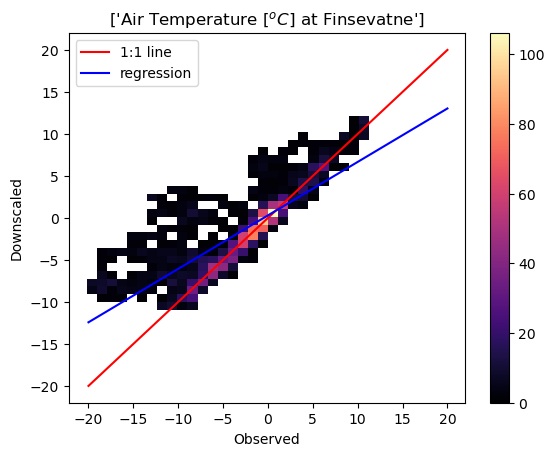

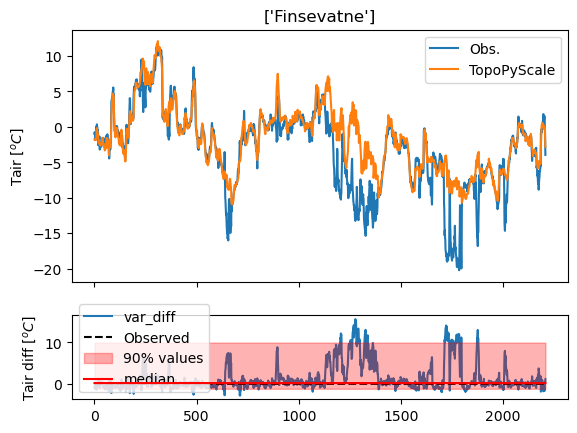

In [11]:
# Air temperature comparison plots

cmp.rename(columns={'air_temperature':'Observed', 'sourceId':'stn_id'}, inplace=True)
#stn = stn.dropna(axis=0)
cmp['var_diff'] = cmp.Downscaled - cmp.Observed

plt.figure()
ax = sns.histplot(x=cmp.Observed, y=cmp.Downscaled, cmap='magma')
ax.figure.colorbar(ax.collections[0])
plt.plot([-20,20], [-20,20], c='r', label='1:1 line')
reg = stats.linregress(cmp.Observed, cmp.Downscaled)
plt.plot([-20,20], np.array([-20,20])*reg.slope + reg.intercept, c='b', label='regression')
plt.ylabel('Downscaled')
plt.xlabel('Observed')
plt.title('Air Temperature [$^{o}C$] at ' + df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values)
plt.legend()

# Plot time series 
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# absolute value
cmp.Observed.plot(ax=ax[0], label='Obs.')
cmp.Downscaled.plot(ax=ax[0], label='TopoPyScale')
ax[0].legend()
ax[0].set_ylabel('Tair [$^{o}C$]')
ax[0].set_title(df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values)
# timeseries difference
cmp.var_diff.plot(ax=ax[1])
(cmp.Observed*0).plot(color='k', linestyle='--')
ax[1].fill_between(cmp.index, (cmp.Observed*0)+cmp.var_diff.quantile(0.05),(cmp.Observed*0) + cmp.var_diff.quantile(0.95), alpha=.3, color='r', zorder=5, label='90% values')
((cmp.Observed*0)+cmp.var_diff.median()).plot(ax=ax[1], label='median', c='r', linestyle='-', zorder=10)
ax[1].legend()
ax[1].set_ylabel('Tair diff [$^{o}C$]')

### Compare Wind Speed

In [20]:
ds_down.ws

<xarray.DataArray 'ws' (point_id: 6, time: 2208)>
dask.array<concatenate, shape=(6, 2208), dtype=float64, chunksize=(1, 2208), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2018-10-01 ... 2018-12-31T23:00:00
  * point_id        (point_id) int32 0 1 2 3 4 5
    reference_time  datetime64[ns] 2018-10-01
Attributes:
    units:          m s**-1
    long_name:      Wind speed
    standard_name:  wind_speed

Text(0, 0.5, 'Ws diff [m.s$^{-1}$]')

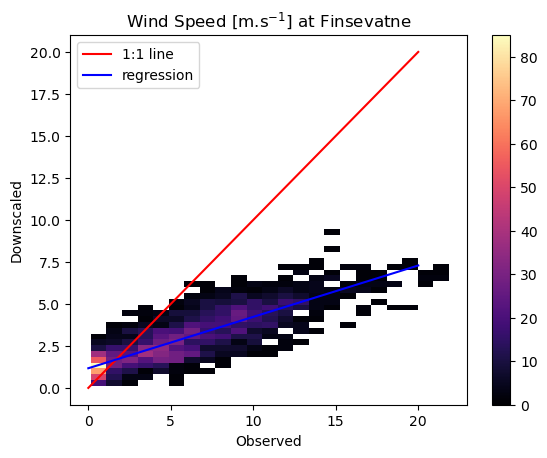

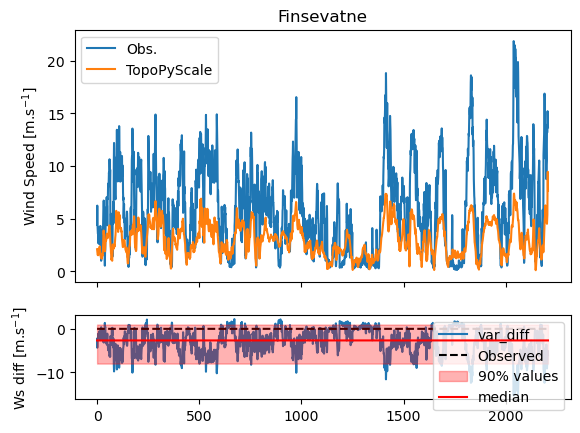

In [21]:
# plot temperature for each station
cmp = None
cmp = pd.DataFrame()
cmp['time'] = ds_down.time
cmp['Downscaled'] = (ds_down.ws.sel(point_id=df_stn.loc[df_stn.stn_number==stn_name[:-2]].index)).copy().drop('point_id')[0].values
cmp['Observed'] = ds.wind_speed.sel(sourceId=stn_name).to_dataframe().wind_speed.resample('1H').mean()[ds_down.time[0].values: ds_down.time[-1].values].values


cmp.rename(columns={'sourceId':'stn_id'}, inplace=True)
#stn = stn.dropna(axis=0)
cmp['var_diff'] = cmp.Downscaled - cmp.Observed

plt.figure()
ax = sns.histplot(x=cmp.Observed, y=cmp.Downscaled, cmap='magma')
ax.figure.colorbar(ax.collections[0])
plt.plot([0,20], [0,20], c='r', label='1:1 line')
reg = stats.linregress(cmp.Observed, cmp.Downscaled)
plt.plot([0,20], np.array([0,20])*reg.slope + reg.intercept, c='b', label='regression')
plt.ylabel('Downscaled')
plt.xlabel('Observed')
plt.title('Wind Speed [m.s$^{-1}$] at ' + df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values[0])
plt.legend()

# Plot time series 
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# absolute value
cmp.Observed.plot(ax=ax[0], label='Obs.')
cmp.Downscaled.plot(ax=ax[0], label='TopoPyScale')
ax[0].legend()
ax[0].set_ylabel('Wind Speed [m.s$^{-1}$]')
ax[0].set_title(df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values[0])
# timeseries difference
cmp.var_diff.plot(ax=ax[1])
(cmp.Observed*0).plot(color='k', linestyle='--')
ax[1].fill_between(cmp.index, (cmp.Observed*0)+cmp.var_diff.quantile(0.05),(cmp.Observed*0)+cmp.var_diff.quantile(0.95), alpha=.3, color='r', zorder=5, label='90% values')
((cmp.Observed*0)+cmp.var_diff.median()).plot(ax=ax[1], label='median', c='r', linestyle='-', zorder=10)
ax[1].legend()
ax[1].set_ylabel('Ws diff [m.s$^{-1}$]')

        

In [22]:
list(ds)

['air_pressure_at_sea_level',
 'air_temperature',
 'relative_humidity',
 'sum(precipitation_amount PT12H)',
 'wind_from_direction',
 'wind_speed']

### Compare Precipitation

Text(0, 0.5, 'Precip diff [mm]')

<Figure size 640x480 with 0 Axes>

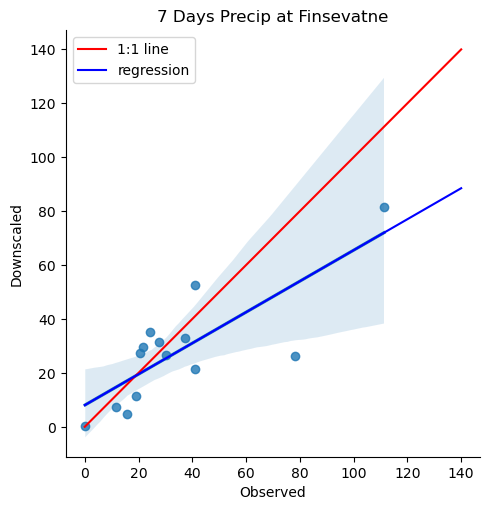

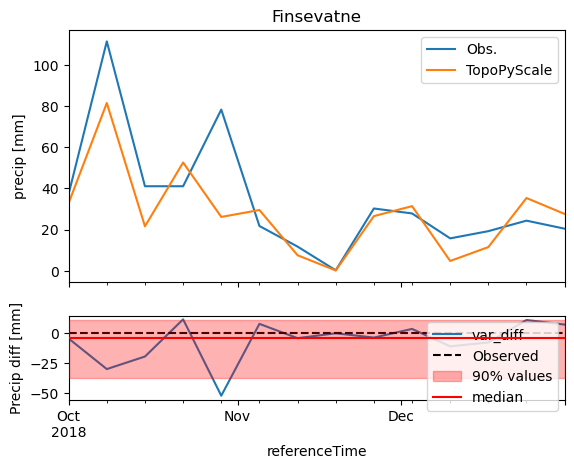

In [52]:
# plot weekly precip for each station
from matplotlib.colors import LogNorm

cmp = None
cmp = pd.DataFrame()
cmp['time'] = ds_down.time

cmp = ds['sum(precipitation_amount PT12H)'].sel(sourceId=stn_name).dropna(dim='referenceTime').copy().to_dataframe().resample('7D').sum()[ds_down.time[0].values: ds_down.time[-1].values]
cmp['Downscaled'] = ds_down.tp[0].drop('point_id').to_dataframe().tp.resample('7D').sum()

cmp.rename(columns={'sum(precipitation_amount PT12H)':'Observed', 'sourceId':'stn_id'}, inplace=True)
#stn = stn.dropna(axis=0)
cmp['var_diff'] = cmp.Downscaled - cmp.Observed


plt.figure()
ax = sns.lmplot(x='Observed', y='Downscaled', data = cmp)
plt.plot([0,140], [0,140], c='r', label='1:1 line')
reg = stats.linregress(cmp.Observed, cmp.Downscaled)
plt.plot([0,140], np.array([0,140])*reg.slope + reg.intercept, c='b', label='regression')
plt.ylabel('Downscaled')
plt.xlabel('Observed')
plt.title('7 Days Precip at ' + df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values[0])
plt.legend()

# Plot time series 
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
# absolute value
cmp.Observed.plot(ax=ax[0], label='Obs.')
cmp.Downscaled.plot(ax=ax[0], label='TopoPyScale')
ax[0].legend()
ax[0].set_ylabel('precip [mm]')
ax[0].set_title(df_stn.Name.loc[df_stn.stn_number==stn_name[:-2]].values[0])
# timeseries difference
cmp.var_diff.plot(ax=ax[1])
(cmp.Observed*0).plot(color='k', linestyle='--')
ax[1].fill_between(cmp.index, (cmp.Observed*0)+cmp.var_diff.quantile(0.05),(cmp.Observed*0)+cmp.var_diff.quantile(0.95), alpha=.3, color='r', zorder=5, label='90% values')
((cmp.Observed*0)+cmp.var_diff.median()).plot(ax=ax[1], label='median', c='r', linestyle='-', zorder=10)
ax[1].legend()
ax[1].set_ylabel('Precip diff [mm]')
